In [1]:
import os
import random
import torch
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lovely_tensors as lt
lt.monkey_patch()

from csng.utils.data import crop
from csng.data import get_dataloaders
from csng.utils.mix import seed_all

### set paths
DATA_PATH = os.environ["DATA_PATH"]
DATA_PATH_CAT_V1 = os.path.join(DATA_PATH, "cat_V1_spiking_model", "50K_single_trial_dataset")
DATA_PATH_MOUSE_V1 = os.path.join(DATA_PATH, "mouse_v1_sensorium22")
DATA_PATH_BRAINREADER = os.path.join(DATA_PATH, "brainreader")

print(f"{DATA_PATH=}")
print(f"{DATA_PATH_CAT_V1=}")
print(f"{DATA_PATH_MOUSE_V1=}")
print(f"{DATA_PATH_BRAINREADER=}")

DATA_PATH='/media/jan/ext_ssd/csng_data'
DATA_PATH_CAT_V1='/media/jan/ext_ssd/csng_data/cat_V1_spiking_model/50K_single_trial_dataset'
DATA_PATH_MOUSE_V1='/media/jan/ext_ssd/csng_data/mouse_v1_sensorium22'
DATA_PATH_BRAINREADER='/media/jan/ext_ssd/csng_data/brainreader'


In [2]:
### setup config
config = {
    "device": os.environ["DEVICE"],
    "seed": 0,
    "save_run": True,
    "wandb": {
        "project": os.environ["WANDB_PROJECT"],
        "group": "cnn_decoder",
    },
    "data": {
        "mixing_strategy": "parallel_min", # needed only with multiple base dataloaders
        "max_training_batches": None,
    },
    "crop_wins": dict(),
}

print(f"... Running on {config['device']} ...")
seed_all(config["seed"])

... Running on cuda:0 ...


In [3]:
### prep data config
# brainreader mouse data
config["data"]["brainreader_mouse"] = {
    "device": config["device"],
    "mixing_strategy": config["data"]["mixing_strategy"],
    "max_batches": None,
    "data_dir": os.path.join(DATA_PATH_BRAINREADER, "data"),
    "batch_size": 8,
    "sessions": list(range(1, 23)),
    "normalize_stim": True,
    "normalize_resp": False,
    "div_resp_by_std": True,
    "clamp_neg_resp": False,
    "additional_keys": None,
    "avg_test_resp": True,
}

# cat v1 data
config["data"]["cat_v1"] = {
    "crop_win": (20, 20),
    "dataset_config": {
        "train_path": os.path.join(DATA_PATH_CAT_V1, "datasets", "train"),
        "val_path": os.path.join(DATA_PATH_CAT_V1, "datasets", "val"),
        "test_path": os.path.join(DATA_PATH_CAT_V1, "datasets", "test"),
        "image_size": [50, 50],
        "crop": False,
        "batch_size": 8,
        "stim_keys": ("stim",),
        "resp_keys": ("exc_resp", "inh_resp"),
        "return_coords": True,
        "return_ori": False,
        "coords_ori_filepath": os.path.join(DATA_PATH_CAT_V1, "pos_and_ori.pkl"),
        "cached": False,
        "stim_normalize_mean": 46.143,
        "stim_normalize_std": 20.420,
        "resp_normalize_mean": torch.load(
            os.path.join(DATA_PATH_CAT_V1, "responses_mean.pt")
        ),
        "resp_normalize_std": torch.load(
            os.path.join(DATA_PATH_CAT_V1, "responses_std.pt")
        ),
    },
}

# mouse v1 data
config["data"]["mouse_v1"] = {
    "dataset_fn": "sensorium.datasets.static_loaders",
    "dataset_config": {
        "paths": [ # from https://gin.g-node.org/cajal/Sensorium2022/src/master
            os.path.join(DATA_PATH_MOUSE_V1, "static21067-10-18-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip"), # M-1
            os.path.join(DATA_PATH_MOUSE_V1, "static22846-10-16-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip"), # M-2
            os.path.join(DATA_PATH_MOUSE_V1, "static23343-5-17-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip"), # M-3
            os.path.join(DATA_PATH_MOUSE_V1, "static23656-14-22-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip"), # M-4
            os.path.join(DATA_PATH_MOUSE_V1, "static23964-4-22-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip"), # M-5
        ],
        "normalize": True,
        "scale": 0.25, # 256x144 -> 64x36
        "include_behavior": False,
        "add_behavior_as_channels": False,
        "include_eye_position": True,
        "exclude": None,
        "file_tree": True,
        "cuda": "cuda" in config["device"],
        "batch_size": 8,
        "seed": config["seed"],
        "use_cache": False,
    },
    "crop_win": (22, 36),
    "skip_train": False,
    "skip_val": False,
    "skip_test": False,
    "normalize_neuron_coords": True,
    "average_test_multitrial": True,
    "save_test_multitrial": True,
    "test_batch_size": 7,
    "device": config["device"],
}

In [4]:
dls, _ = get_dataloaders(config)
for tier, data_dict in dls.items():
    print(f"{tier}:")
    for data_name, dl in data_dict.items():
        for data_key, dset in zip(dl.data_keys, dl.datasets):
            config["crop_wins"][data_key] = tuple(dset[0].images.shape[-2:])
        print(f"  {data_name}: {len(dl)} batches")
        print(f"    data keys: {', '.join(dl.data_keys)}")
        print(f"    size of datasets: {', '.join([str(len(dl) * _dl.batch_size) for _dl in dl.dataloaders])}")

train:
  brainreader_mouse: 563 batches
    data keys: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22
    size of datasets: 4504, 4504, 4504, 4504, 4504, 4504, 4504, 4504, 4504, 4504, 4504, 4504, 4504, 4504, 4504, 4504, 4504, 4504, 4504, 4504, 4504, 4504
  mouse_v1: 559 batches
    data keys: 21067-10-18, 22846-10-16, 23343-5-17, 23656-14-22, 23964-4-22
    size of datasets: 4472, 4472, 4472, 4472, 4472
  cat_v1: 5625 batches
    data keys: cat_v1
    size of datasets: 45000
val:
  brainreader_mouse: 63 batches
    data keys: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22
    size of datasets: 504, 504, 504, 504, 504, 504, 504, 504, 504, 504, 504, 504, 504, 504, 504, 504, 504, 504, 504, 504, 504, 504
  mouse_v1: 62 batches
    data keys: 21067-10-18, 22846-10-16, 23343-5-17, 23656-14-22, 23964-4-22
    size of datasets: 496, 496, 496, 496, 496
  cat_v1: 625 batches
    data keys: cat_v1
    size of datasets: 5000
test:
  bra

Training dataset:	 99088 samples
Validation dataset:	 11088 samples
Test dataset:		 1064 samples

stimuli:
  torch.Size([8, 1, 36, 64])
  min=-2.330  max=2.911
  mean=0.036  std=1.218
responses:
  torch.Size([8, 9395])
  min=0.000  max=21.506
  mean=0.305  std=0.491


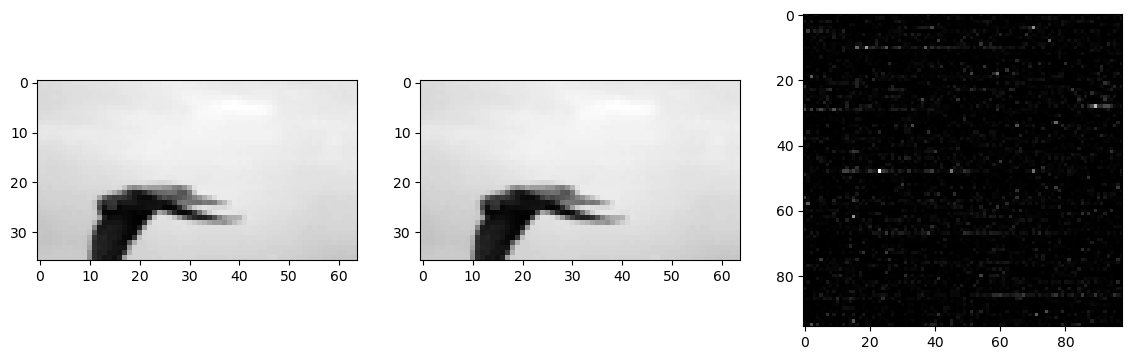

In [5]:
### show data
data_name = "brainreader_mouse"
sample_data_key = "1"
tier = "test"
sample_idx = 0

datapoint = next(iter(dls[tier][data_name].dataloaders[0]))
stim, resp = datapoint.images, datapoint.responses
print(
    f"Training dataset:\t {sum(len(dl) * dl.batch_size for dl in dls['train'][data_name].dataloaders)} samples"
    f"\nValidation dataset:\t {sum(len(dl) * dl.batch_size for dl in dls['val'][data_name].dataloaders)} samples"
    f"\nTest dataset:\t\t {sum(len(dl) * dl.batch_size for dl in dls['test'][data_name].dataloaders)} samples"

    "\n\nstimuli:"
    f"\n  {stim.shape}"
    f"\n  min={stim.min().item():.3f}  max={stim.max().item():.3f}"
    f"\n  mean={stim.mean().item():.3f}  std={stim.std().item():.3f}"
    "\nresponses:"
    f"\n  {resp.shape}"
    f"\n  min={resp.min().item():.3f}  max={resp.max().item():.3f}"
    f"\n  mean={resp.mean().item():.3f}  std={resp.std().item():.3f}"
)

### plot sample data
fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(131)
ax.imshow(stim[sample_idx].cpu().squeeze().unsqueeze(-1), cmap="gray")

ax = fig.add_subplot(132)
ax.imshow(crop(stim[sample_idx].cpu(), config["crop_wins"][sample_data_key]).squeeze().unsqueeze(-1), cmap="gray")

ax = fig.add_subplot(133)
to_show = resp[sample_idx].cpu()
### pad with zeros
if to_show.shape[-1] % (w := np.sqrt(resp[sample_idx].cpu().shape[0]).astype(int)) != 0:
    to_show = torch.cat([to_show, torch.zeros(w - to_show.shape[-1] % w)], dim=-1)
ax.imshow(to_show.view(w, -1).squeeze(0).unsqueeze(-1), cmap="gray")